# Project: Image Classification and Regression
## Florentin Guth

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


## Dataset Generation

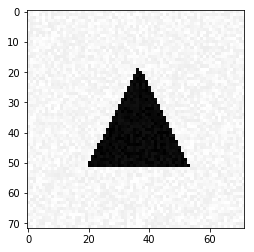

In [3]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    for i in range(nb_samples):
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

## Simple Classification

In [4]:
d1 = (generate_dataset_classification(300, 20), generate_dataset_classification(300, 20)) # easy
d2 = (generate_dataset_classification(300, 20, True), generate_test_set_classification()) # hard

In [5]:
def train(model, optimizer, dataset, loss='categorical_crossentropy', epochs=10, verbose=0):
    (X_train, Y_train), (X_test, Y_test) = dataset
    model.compile(optimizer, loss=loss, metrics=['acc'])
    model.fit(X_train, (Y_train if Y_train.ndim > 1 else to_categorical(Y_train)), epochs=epochs, batch_size=32, verbose=verbose)
    metrics = model.evaluate(X_test, (Y_test if Y_test.ndim > 1 else to_categorical(Y_test)), verbose=0)
    print('Metrics for optimizer {}: {}'.format(
        optimizer.__class__.__name__, np.transpose((model.metrics_names, metrics)).reshape(-1)))
    return model

def fcmodel():
    return Sequential([Dense(3, activation='softmax', input_shape=(IMAGE_SIZE*IMAGE_SIZE,))])
    
sgd = SGD(lr=1e-3, momentum=0.9, nesterov=True)
adam = Adam(lr=1e-3, amsgrad=True)

model_sgd = train(fcmodel(), sgd, d1)
model_adam = train(fcmodel(), adam, d1)

Metrics for optimizer SGD: ['loss' '0.2607594541708628' 'acc' '0.8766666666666667']
Metrics for optimizer Adam: ['loss' '0.18404012322425842' 'acc' '0.99']


The Adam optimizer converges faster (and there is no overfitting here, as the testing accuracy is 99%), thanks to its adaptive learning rate.

## Visualization of the Solution

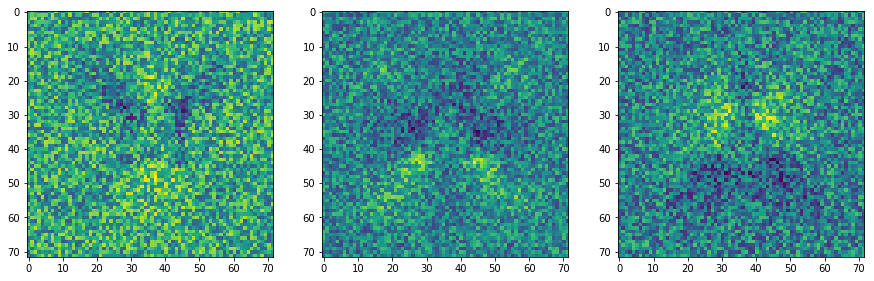

In [6]:
a, b = model_adam.get_weights()
plt.figure(figsize=(15,5))
for i, w in enumerate(a.transpose()):
    plt.subplot(1, 3, i+1)
    plt.imshow(w.reshape((IMAGE_SIZE, IMAGE_SIZE)))
plt.show()

We do not recognise shapes in the weights of the layers, which is surprising. The network probably overfitted the train/test dataset and will not be robust to changes in size/rotation/position of the shapes. The weights do seem to be sensible to separate areas of the image though (top and bottom center for the rectangle, bottom left and right for the disk and center for the triangle).

## A More Difficult Classification Problem

In [57]:
train(fcmodel(), adam, d2)

Metrics for optimizer Adam: ['loss' '0.8633301726977031' 'acc' '0.5399999996026357']


As expected, the testing accuracy is much lower here. The dense architecture is not adapted at all to the problem.

In [85]:
def convmodel():
    return Sequential([
        Reshape((IMAGE_SIZE, IMAGE_SIZE, 1), input_shape=(IMAGE_SIZE*IMAGE_SIZE,)),
        Conv2D(32, 5, activation='relu'),
        AveragePooling2D(5, 1),
        Conv2D(32, 5, activation='relu'),
        AveragePooling2D(5, 1),
        Flatten(),
        Dense(3, activation='softmax'),
    ])

train(convmodel(), Adam(lr=1e-3, amsgrad=True), d2, verbose=1, epochs=20)

Epoch 1/20
300/300 [==============================] - 3s 8ms/step - loss: 1.3044 - acc: 0.3333
Epoch 2/20
300/300 [==============================] - 1s 3ms/step - loss: 0.9831 - acc: 0.5200
Epoch 3/20
300/300 [==============================] - 1s 3ms/step - loss: 0.8173 - acc: 0.6367
Epoch 4/20
300/300 [==============================] - 1s 3ms/step - loss: 0.6893 - acc: 0.6700
Epoch 5/20
300/300 [==============================] - 1s 3ms/step - loss: 0.6328 - acc: 0.7333
Epoch 6/20
300/300 [==============================] - 1s 3ms/step - loss: 0.5492 - acc: 0.7833
Epoch 7/20
300/300 [==============================] - 1s 3ms/step - loss: 0.5436 - acc: 0.7433
Epoch 8/20
300/300 [==============================] - 1s 3ms/step - loss: 0.4869 - acc: 0.8167
Epoch 9/20
300/300 [==============================] - 1s 3ms/step - loss: 0.4534 - acc: 0.8000
Epoch 10/20
300/300 [==============================] - 1s 3ms/step - loss: 0.4276 - acc: 0.8200
Epoch 11/20
300/300 [============================

Convolutions are much better adapted to the problem than dense layers. They enforce translation invariance. Since the data is limited, there is significant overfitting.

## A Regression Problem

(300, 5184) (300, 6)


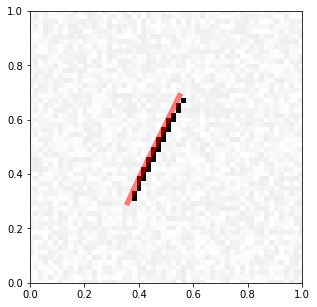

In [86]:
d3 = generate_dataset_regression(300, 20), generate_test_set_regression()
print(d3[0][0].shape, d3[0][1].shape)
visualize_prediction(d3[0][0][0], d3[0][1][0])

In [129]:
Y_train = d3[0][1] # 300x6
# def statistics(x):
#     μ = x.mean(axis=0)
#     centered = x - μ[None]
#     σ = centered.std(axis=0)
#     return μ, σ, centered / σ
mean = Y_train.mean(axis=0)
std = (Y_train - mean[None,:]).std(axis=0)
def normalize(x):
    return x * std[None] + mean[None]
def regmodel():
    return Sequential([
        Reshape((IMAGE_SIZE, IMAGE_SIZE, 1), input_shape=(IMAGE_SIZE*IMAGE_SIZE,)),
        Conv2D(32, 5, activation='relu'),
        MaxPooling2D(5, 1),
#         Conv2D(32, 5, activation='relu'),
#         AveragePooling2D(5, 1),
        Flatten(),
        Dense(6),
        Lambda(normalize)
    ])

model = train(regmodel(), Adam(lr=1e-3, amsgrad=True), d3, loss='mean_squared_error', verbose=1, epochs=30)

Epoch 1/30
300/300 [==============================] - 3s 9ms/step - loss: 1.1451 - acc: 0.1933
Epoch 2/30
300/300 [==============================] - 0s 1ms/step - loss: 0.2352 - acc: 0.3067
Epoch 3/30
300/300 [==============================] - 0s 1ms/step - loss: 0.0807 - acc: 0.3067
Epoch 4/30
300/300 [==============================] - 0s 1ms/step - loss: 0.0714 - acc: 0.3467
Epoch 5/30
300/300 [==============================] - 0s 1ms/step - loss: 0.0614 - acc: 0.3733
Epoch 6/30
300/300 [==============================] - 0s 1ms/step - loss: 0.0566 - acc: 0.4333
Epoch 7/30
300/300 [==============================] - 0s 1ms/step - loss: 0.0527 - acc: 0.4900
Epoch 8/30
300/300 [==============================] - 0s 1ms/step - loss: 0.0496 - acc: 0.4700
Epoch 9/30
300/300 [==============================] - 0s 1ms/step - loss: 0.0466 - acc: 0.4833
Epoch 10/30
300/300 [==============================] - 0s 1ms/step - loss: 0.0433 - acc: 0.5133
Epoch 11/30
300/300 [============================

787270


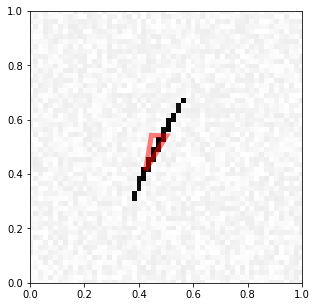

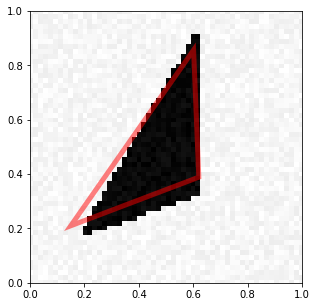

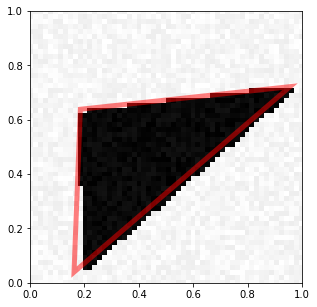

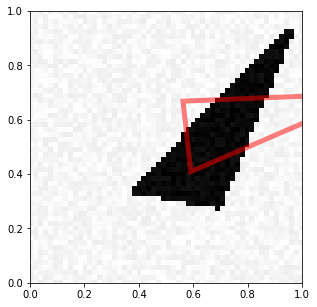

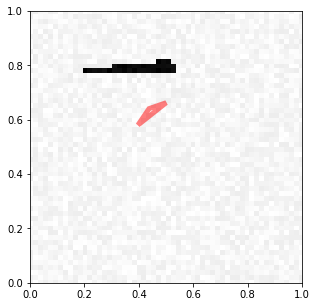

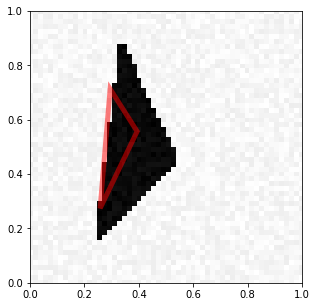

In [137]:
print(model.count_params())
for test in [False, True]:
    for idx in range(3):
        visualize_prediction(d3[int(test)][0][idx], model.predict(d3[int(test)][0][None,idx]))

There is still significant overfitting occurring. There is much more parameters than the number of training examples, so this is to be expected.

## Image Denoising

Note: the original [SegNet](https://arxiv.org/abs/1505.07293) seems to use a particular upsampling method in the decoder: it remembers the pooling indices of the local maxima in the encoder and scatters the lower-resolution image into the higher-resolution one at those indices. Since this is not implemented in Keras, and I believe implementing a custom layer is out of scope for this mini-project, I chose to use the simpler 'nearest' upsampling scheme instead. I chose to follow the course, so I added ReLUs and BatchNorm to the decoder as well, contrary to the original implementation.

In [139]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noise = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata_noise, imdata

def generate_dataset_denoising(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk(noise, free_location)
        else:
            X[i], Y[i] = generate_a_triangle(noise, free_location)[0]
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_denoising():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising(300, 20, True)
    return [X_test, Y_test]

d4 = generate_dataset_denoising(1000, 20, True), generate_test_set_denoising()

In [152]:
def hourglass(num_blocks=3, num_channels=16, kernel_size=5):
    model = Sequential([Reshape((IMAGE_SIZE, IMAGE_SIZE, 1), input_shape=(IMAGE_SIZE*IMAGE_SIZE,)),])
    for _ in range(num_blocks):
        model.add(Conv2D(num_channels, kernel_size, padding='same', kernel_initializer='identity'))
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(MaxPooling2D(2))
    for _ in range(num_blocks):
        model.add(UpSampling2D(2))
        model.add(Conv2D(num_channels, kernel_size, padding='same'))
        model.add(BatchNormalization())
        model.add(ReLU())
    model.add(Conv2D(1, 1)) # 1x1 conv to go to 1 channel
    model.add(Flatten())
    return model

model = train(hourglass(), Adam(lr=1e-2, amsgrad=True), d4, loss='mean_squared_error', verbose=1, epochs=50)

Epoch 1/50
1000/1000 [==============================] - 6s 6ms/step - loss: 57064.3136 - acc: 0.0000e+00
Epoch 2/50
1000/1000 [==============================] - 3s 3ms/step - loss: 53445.7908 - acc: 0.0000e+00
Epoch 3/50
1000/1000 [==============================] - 3s 3ms/step - loss: 47330.1743 - acc: 0.0000e+00
Epoch 4/50
1000/1000 [==============================] - 3s 3ms/step - loss: 38875.3560 - acc: 0.0000e+00
Epoch 5/50
1000/1000 [==============================] - 3s 3ms/step - loss: 28924.8786 - acc: 0.0000e+00
Epoch 6/50
1000/1000 [==============================] - 3s 3ms/step - loss: 18996.0953 - acc: 0.0000e+00
Epoch 7/50
1000/1000 [==============================] - 3s 3ms/step - loss: 10770.4850 - acc: 0.0000e+00
Epoch 8/50
1000/1000 [==============================] - 3s 3ms/step - loss: 5166.4545 - acc: 0.0000e+00
Epoch 9/50
1000/1000 [==============================] - 3s 3ms/step - loss: 2196.9511 - acc: 0.0000e+00
Epoch 10/50
1000/1000 [==============================] - 

32897


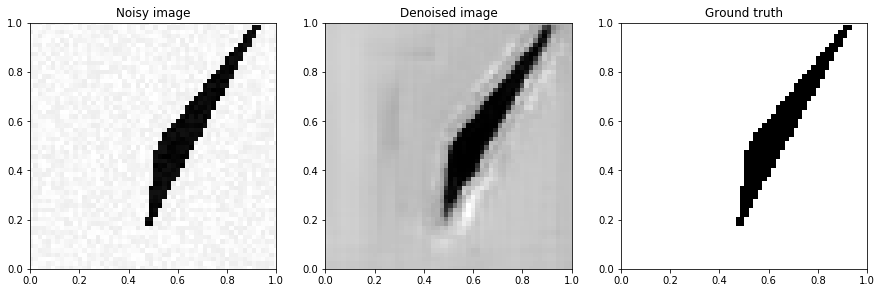

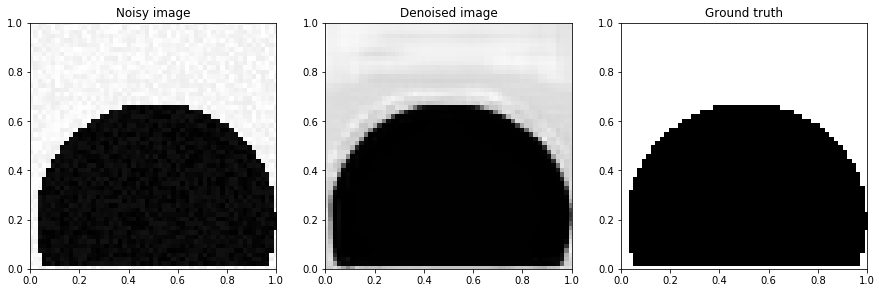

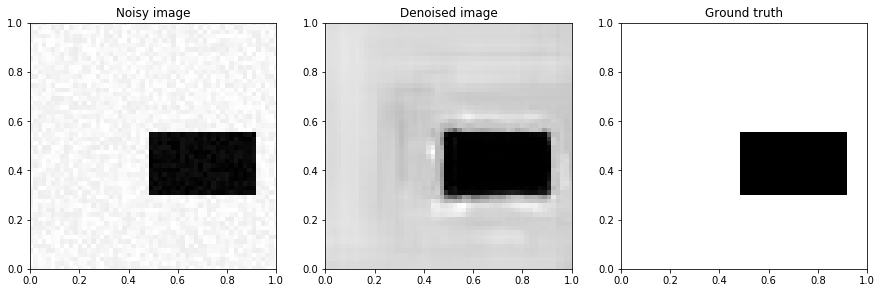

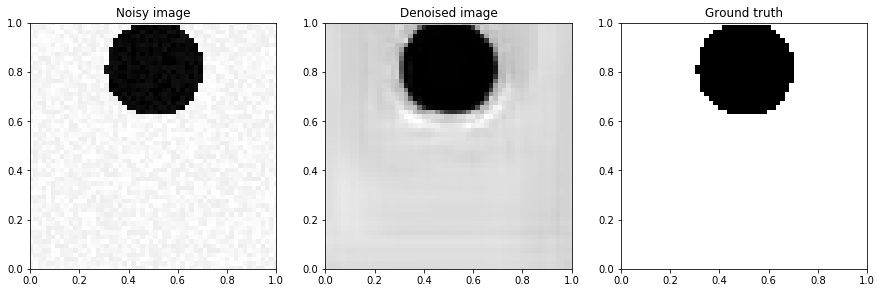

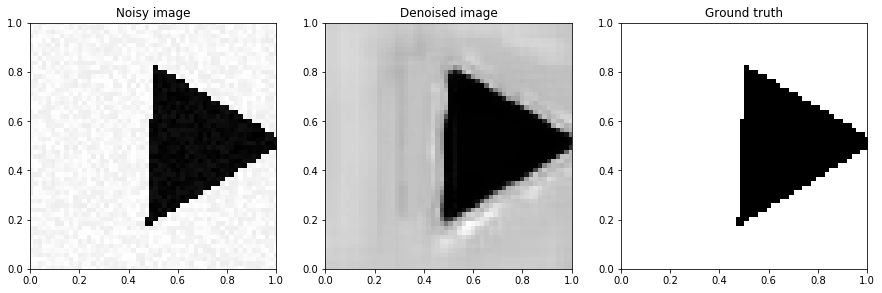

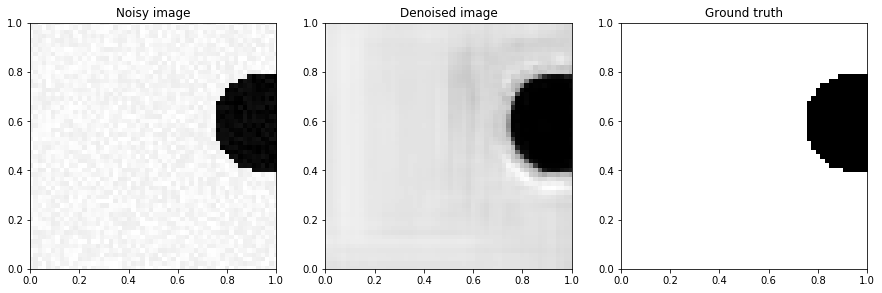

In [153]:
def show_img(x):
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    plt.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    plt.xlim([0,1])
    plt.ylim([0,1])
    
def visualize_denoising(x, y):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Noisy image')
    show_img(x)
    
    plt.subplot(1, 3, 2)
    plt.title('Denoised image')
    show_img(model.predict(x[None]))
    
    plt.subplot(1, 3, 3)
    plt.title('Ground truth')
    show_img(y)
    
    plt.show()
    
print(model.count_params())
for test in [False, True]:
    for idx in range(3):
        visualize_denoising(d4[int(test)][0][idx], d4[int(test)][1][None,idx])

The denoised images are very blurred and don't even learn that the images are black and white (without any grayscales). The gray in the background probably comes from blurring the noise in the original background. It seems that the network learns to not smooth edges though, as we can see a ring of white around the borders.

A better initialization so that the encoder is close to the identity would probably speed up the training and allow to fine-tune it a little more.